In [1186]:
import seaborn as sns
import sdeint
import matplotlib.pyplot as plt
import pandas as pd
import sympy as smp
from time import perf_counter
from itertools import combinations
import numpy as np
import pycatch22 as catch22
from sympy import real_roots
from scipy.stats import pearsonr
import scipy
import statistics
import scipy.cluster.hierarchy as sch
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer, FunctionTransformer
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.decomposition import PCA, FactorAnalysis
from scipy.spatial.distance import pdist, squareform, cdist

In [533]:
def gen_limitCycle(num_samples): # num samples
    # hopf
    eta_val_hopf = np.random.uniform(0.01, 0.7, size=num_samples)
    mu_val_hopf = np.random.uniform(0.01, 5, size=num_samples)
    sols_list = list()
    dt = 0.01
    tspan = np.arange(0, 55, dt)
    print('Generating Limit Cycle Instances...')
    for i in range(num_samples):
        mu = mu_val_hopf[i]
        eta = eta_val_hopf[i]
        def f(state, t):
            x, y = state[0], state[1]
            dxdt = -y + (mu - x**2 - y**2) * x
            dydt = x + (mu - x **2 - y **2) * y
            return dxdt, dydt
        ic = np.array(np.random.uniform(size=2))
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
        sols_list.append(sol[500:])
    ts_hopf = np.array([sols_list[i][:,0] for i in range(len(sols_list))])
    features_hopf = np.array([catch22.catch22_all(ts_hopf[i,:])['values'] for i in range(len(ts_hopf))])
    df = pd.DataFrame(features_hopf)
    df['mu'] = mu_val_hopf
    df['eta'] = eta_val_hopf
    df['regime'] = 'HopfLC'
    return ts_hopf, df

In [527]:
def gen_fixedpoint(num_samples):
    num_samples = round(num_samples/3)
    if num_samples % 2 == 1:
        num_samples = num_samples + 1
    
    #system 1 - hookes
    eta_val_hookes = np.random.uniform(0.01, 1, size=num_samples)
    mu_val_hookes = np.random.uniform(-1.1, -0.98, size=num_samples)
    sols_list = list()
    dt = 0.01
    tspan = np.arange(0, 55, dt)
    print('Generating Fixed Point Instances...')
    for i in range(num_samples):
        mu = mu_val_hookes[i]
        eta = eta_val_hookes[i]
        def f(state, t):
            x = state[0]
            dxdt = mu *x
            return dxdt
        ic = np.array([np.random.uniform()])
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array([ic]), tspan)
        sols_list.append(sol[500:])
    ts_hookes = np.array([sols_list[i][:,0] for i in range(len(sols_list))])
    features_hookes = np.array([catch22.catch22_all(ts_hookes[i,:])['values'] for i in range(len(ts_hookes))])
    df_hookes = pd.DataFrame(features_hookes)
    df_hookes['mu'] = mu_val_hookes
    df_hookes['eta'] = eta_val_hookes
    df_hookes['regime'] = 'HookesFP'

    # system 2 - hopf 
    eta_val_hopf = np.random.uniform(0.01, 1, size=num_samples)
    mu_val_hopf = np.random.uniform(-5, -0.01, size=num_samples) # sample 
    sols_list = list()
    dt = 0.01
    tspan = np.arange(0, 55, dt)
    for i in range(num_samples):
        mu = mu_val_hopf[i]
        eta = eta_val_hopf[i]
        def f(state, t):
            x, y = state[0], state[1]
            dxdt = -y + (mu - x**2 - y**2) * x
            dydt = x + (mu - x **2 - y **2) * y
            return dxdt, dydt
        ic = np.array(np.random.uniform(size=2))
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
        sols_list.append(sol[500:])
    ts_hopf = np.array([sols_list[i][:,0] for i in range(len(sols_list))])
    features_hopf = np.array([catch22.catch22_all(ts_hopf[i,:])['values'] for i in range(len(ts_hopf))])
    df_hopf = pd.DataFrame(features_hopf)
    df_hopf['mu'] = mu_val_hopf
    df_hopf['eta'] = eta_val_hopf
    df_hopf['regime'] = 'HopfFP'

    # system 3 - bistable
    eta_val_bistable = np.random.uniform(0.01, 1, size=num_samples)
    mu_val_bistable = np.concatenate([np.random.uniform(-5, -0.385, size=int(num_samples/2)), np.random.uniform(0.385, 5, size=int(num_samples/2))])
    sols_list = list()
    dt = 0.01
    tspan = np.arange(0, 55, dt)
    for i in range(num_samples):
        mu = mu_val_bistable[i]
        eta = eta_val_bistable[i]
        def f(state, t):
            x = state
            dxdt = mu + x - x**3
            return dxdt
        ic = np.array([np.random.uniform()])
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
        sols_list.append(sol[500:])
    ts_bistable = np.array([sols_list[i][:,0] for i in range(len(sols_list))])
    features_bistable = np.array([catch22.catch22_all(ts_bistable[i,:])['values'] for i in range(len(ts_bistable))])
    df_bistable = pd.DataFrame(features_bistable)
    df_bistable['mu'] = mu_val_bistable
    df_bistable['eta'] = eta_val_bistable
    df_bistable['regime'] = 'BistableFP'

    ts_fixedpt = np.vstack([ts_hookes, ts_hopf, ts_bistable])
    df_fixedpt = pd.concat([df_hookes, df_hopf, df_bistable])


    return ts_fixedpt, df_fixedpt

In [534]:
def gen_switching(num_samples):
    eta_val_bistable = list()
    mu_val_bistable = list()
    sols_list = list()
    dt = 0.01
    tspan = np.arange(0, 55, dt)
    count = 0 
    print('Generating Bistable Switching Instances...')
    while count < num_samples:
        mu = np.random.uniform(low=-0.38487849, high=0.38487849)
        eta = np.random.uniform(0.001, 1)
        def f(state, t):
            x = state
            dxdt = mu + x - x**3
            return dxdt
        ic = np.array([np.random.uniform()])
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
        X = smp.Symbol('x', real=True)
        eq = mu + X - X**3
        roots = [j.n(6) for j in real_roots(eq, X)]
        max_root = np.max(roots)
        min_root = np.min(roots)
        max_actual = np.max(sol[500:])
        min_actual = np.min(sol[500:])
        # check for switching condition
        if (max_actual >= max_root) & (min_actual <= min_root):
            eta_val_bistable.append(eta)
            mu_val_bistable.append(mu)
            sols_list.append(sol[500:])
            count += 1
    ts_bistable = np.array([sols_list[i][:,0] for i in range(len(sols_list))])
    features_bistable = np.array([catch22.catch22_all(ts_bistable[i,:])['values'] for i in range(len(ts_bistable))])
    df = pd.DataFrame(features_bistable)
    df['mu'] = mu_val_bistable
    df['eta'] = eta_val_bistable
    df['regime'] = 'BistableSW'
    return ts_bistable, df

In [577]:
samples_per_class = 5000
ts_sw, df_sw = gen_switching(samples_per_class)
ts_fp, df_fp = gen_fixedpoint(samples_per_class)
ts_lc, df_lc = gen_limitCycle(samples_per_class)

Generating Bistable Switching Instances...
Generating Fixed Point Instances...
Generating Limit Cycle Instances...


In [587]:
instances = np.vstack([df_fp.iloc[:,:22], df_lc.iloc[:,:22], df_sw.iloc[:,:22]])
# GROUND TRUTH LABELS
labels_encoding = np.concatenate([np.tile(0, len(ts_fp)), np.tile(1, len(ts_lc)), np.tile(2, len(ts_sw))]) # 0 = FP, 1 = LC, 2 = BS

Preprocess

In [873]:
rs_fit = RobustScaler().fit(instances)
rs = rs_fit.transform(instances)
box_cox_fit = PowerTransformer().fit(rs)
box_cox = box_cox_fit.transform(rs)
zscore_fit = StandardScaler().fit(box_cox)
zscored = zscore_fit.transform(box_cox)

Compute correlation between features and desired outcome i.e. dynamical regime (class label) for high level inference but could be control parameter for lower level inference with higher precision.

Note that the pearson correlation is only appropriate for measuring linear relationships between variables which is particularly useful for subsequent PCA dim reduction. 

In [874]:
# find the pearson correlation between each feature and the output label/class
correlations = list()
for i in range(zscored.shape[1]):
    corr, _ = pearsonr(zscored[:,i], labels_encoding)
    correlations.append(corr)

In [875]:
print(np.abs(correlations))

[0.01440517 0.01826391 0.82763231 0.75155694 0.38070389 0.00294711
 0.43878373 0.74980405 0.62372024 0.53631995 0.4251219  0.23336703
 0.08782875 0.13605117 0.08083042 0.52396631 0.06875851 0.3637302
 0.06967924 0.23825701 0.82622439 0.4767177 ]


In [876]:
# sort from smallest (after taking abs value) to largest and extract subset of highest correlations
np.sort(np.abs(correlations))
# arbitrary take all features with correlations greater than 0.3?
high_corr_indices = np.argwhere(np.abs(correlations) > 0.3)
features_subset = zscored[:, high_corr_indices].reshape(zscored.shape[0], -1)
features_subset.shape

(15004, 12)

In [12]:
# Cluster features using similarity metric 1 - |rho| where rho is the pearson correlation between pairs of features
# so similar have smaller value and dissimilar have larger value
# Accept one feature from each cluster as reduced subset -> consider all possible combinations

In [877]:
n_clusters = 4 # hyperparam, needs to be specified ahead of time (to be optimised based on target outcome)
df = pd.DataFrame(features_subset).corr() # compute feature-feature correlation
dissimilarity = 1 - abs(df)
#dissimilarity

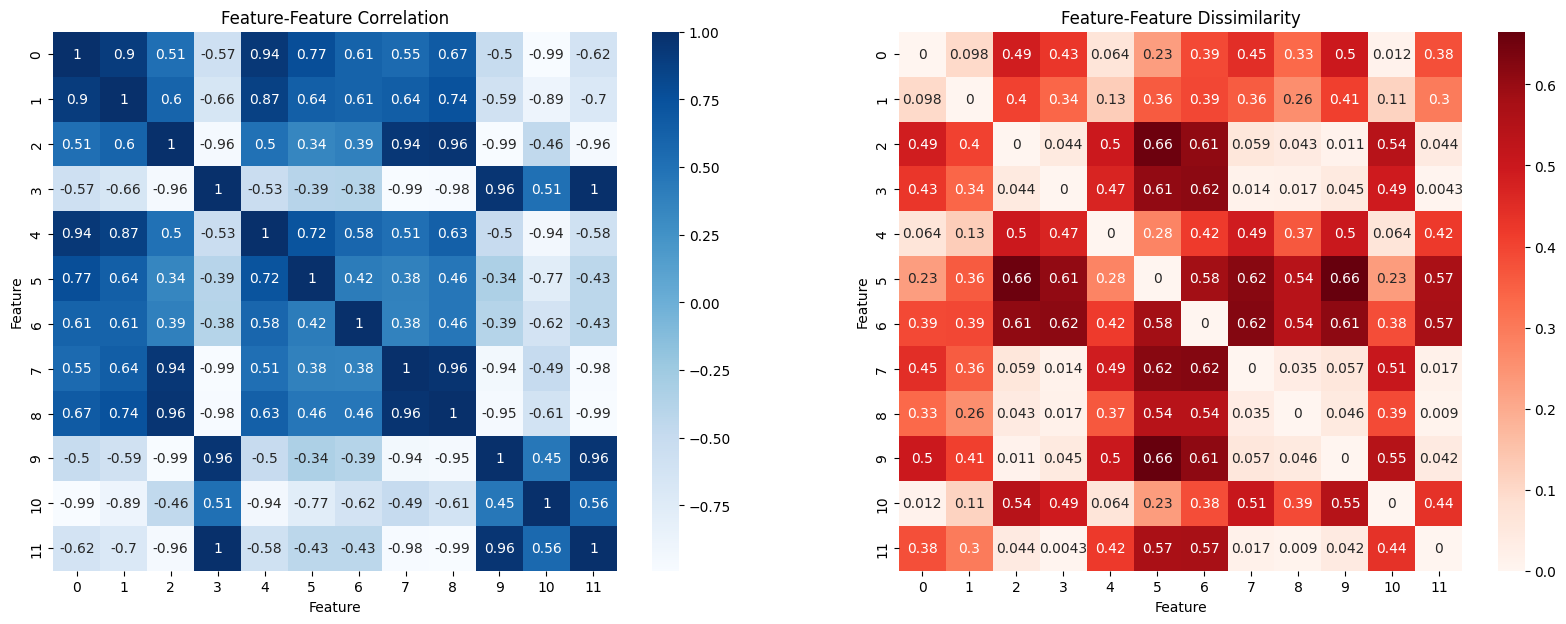

In [878]:
fig, ax = plt.subplots(1, 2, figsize=(20,7))
sns.heatmap(df, annot=True, cmap='Blues', ax=ax[0])
ax[0].set_xlabel('Feature')
ax[0].set_ylabel('Feature')
ax[0].set_title('Feature-Feature Correlation')

sns.heatmap(dissimilarity, annot=True, cmap='Reds', ax=ax[1])
ax[1].set_xlabel('Feature')
ax[1].set_ylabel('Feature')
ax[1].set_title('Feature-Feature Dissimilarity')
plt.show()

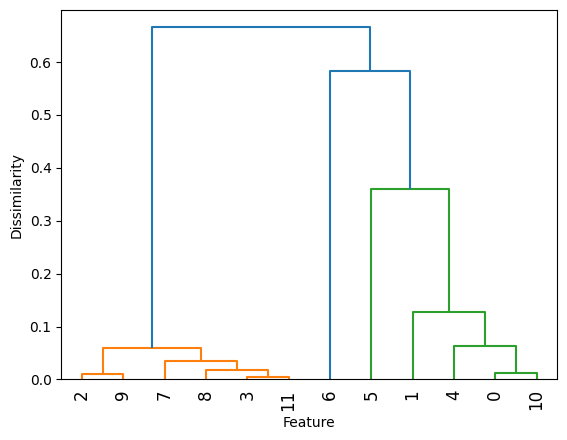

In [596]:
Z = sch.linkage(squareform(dissimilarity), 'complete')
sch.dendrogram(Z, labels=df.columns, orientation='top', leaf_rotation=90)
plt.xlabel('Feature')
plt.ylabel('Dissimilarity')
plt.show()

In [879]:
# clusterize the data
threshold = 0.04
labels = sch.fcluster(Z, threshold, criterion='distance')

In [880]:
print(np.sort(labels))
print(np.argsort(labels))

[1 1 2 2 2 2 3 3 4 5 6 7]
[ 2  9  3  7  8 11  0 10  4  1  5  6]


Get all possible permutations/combinations of features by selecting one feature from each cluster and project subset using PCA (for each possibility)

In [104]:
# automate
subsets_final_idx = np.array([[2, 3, 0, 4, 1, 5, 6], [2, 7, 0, 4, 1, 5, 6], [2, 8, 0, 4, 1, 5, 6], [2, 10, 0, 4, 1, 5, 6], 
    [9, 3, 0, 4, 1, 5, 6], [9, 7, 0, 4, 1, 5, 6], [9, 8, 0, 4, 1, 5, 6], [9, 10, 0, 4, 1, 5, 6]]) # indx of feature combinations

Loop through each combination of features and compute accuracy on new data via. epsilon curve

In [376]:
# make 10 fold cv inspired method for epsilon curve to stick error bars on things

Pre-processing as per ISA methodology

In [881]:
def bounding_transformer(X):
    medians = np.median(X, axis=0)

    # calculate iqr
    q75, q25 = np.percentile(X, [75, 25], axis=0)
    iqrs = q75- q25
    
    # calculate bounds
    lower_bounds = medians - (5*iqrs)
    upper_bounds = medians + (5*iqrs)

    # Bound the values
    bounded_values = np.maximum(lower_bounds, np.minimum(X, upper_bounds))
    return bounded_values
bounding_transformer = FunctionTransformer(bounding_transformer)

In [882]:
test = bounding_transformer.fit(instances)
out = test.transform(instances)

In [883]:
# Box-Cox Transformation
box_cox_fit = PowerTransformer(standardize=True).fit(out)
box_cox = box_cox_fit.transform(out)

In [884]:
pca_fit = PCA(n_components=2).fit(box_cox)
pca = pca_fit.transform(box_cox)

Mixed Sigmoid alternative

In [957]:
def MixedSigmoid(X):
    iqrX = scipy.stats.iqr(X, axis=0) # compute interquartile range
    Xhat = X
    for index, iqr in enumerate(iqrX):
        if iqr == 0:
            # apply standard logistic sigmoid
            meanX = np.mean(X[:, index])
            stdX = np.std(X[:, index])
            Xhat[:, index] = 1./(1+np.exp(-(X[:, index]-meanX)/stdX))
        else:
            # apply outlier robust sigmoid
            medianX = np.median(X[:, index])
            Xhat[:, index] = 1./(1 + np.exp(-(X[:, index]-medianX)/(1.35*iqrX[index])))
    
    # rescale to unit interval
    minX = np.min(Xhat, axis=0)
    maxX = np.max(Xhat, axis=0)

    Xhat = (Xhat - minX)/(maxX-minX)
    
    return Xhat

In [959]:
sig = MixedSigmoid(instances)

Use the test/train split function from sklearn

In [963]:
X_train, X_test, y_train, y_test = train_test_split(sig, labels_encoding, test_size=0.3)

In [964]:
print(X_train.shape)
print(X_test.shape)

(10502, 22)
(4502, 22)


In [965]:
pca_fit = PCA(n_components=2).fit(X_train) # replace with dim. reduction method of choice
pca_train = pca_fit.transform(X_train)
pca_test = pca_fit.transform(X_test)


Inspect

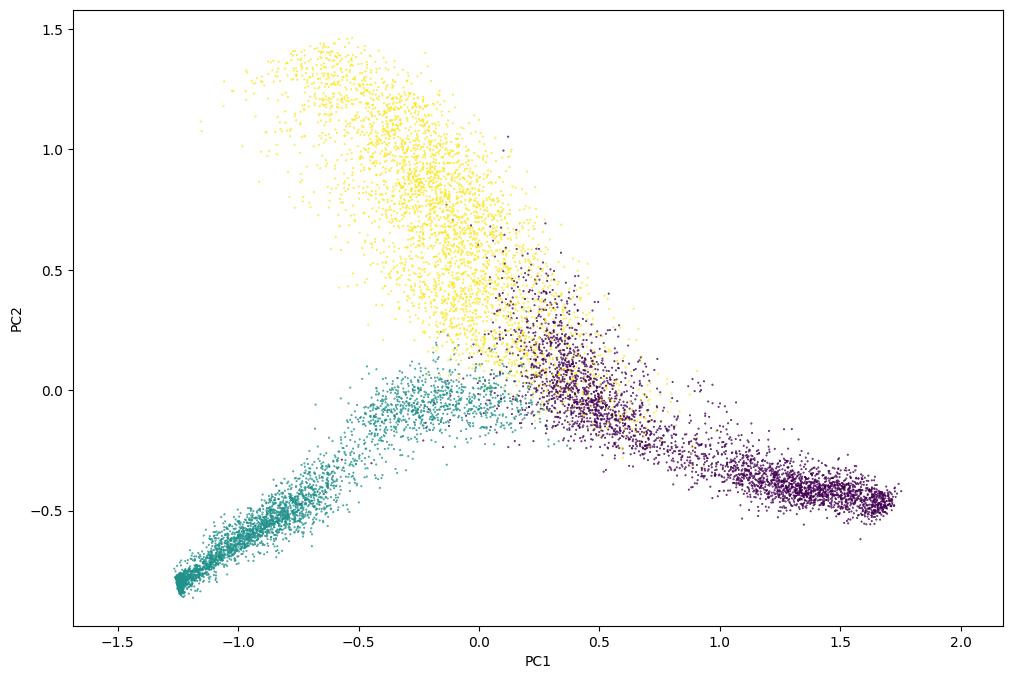

In [966]:
plt.figure(figsize=(12,8))
plt.scatter(pca_train[:,0], pca_train[:,1], s=0.2, c=y_train)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.axis('equal')
plt.show()

In [967]:
# store num correct for each epsilon
epsilons = np.linspace(0.1, 2, 100)
accuracies = list()

#
lower_lim_eps = list() # for cases where no instances are within epsilon radius, store euclid. dist to closest point
# would be interesting to see how this changes as num of samples increases

for epsilon in epsilons:
    # cycle through N validation samples
    predictions = list()
    for index, pos in enumerate(pca_test): 
        # pca_subset
        x, y = pos
        neighbours_idx = np.argwhere(((pca_train[:,0] - x)**2 + (pca_train[:,1] - y)**2) < epsilon**2)
        # check to see if neighbouring points exist for current epsilon value
        if len(neighbours_idx) == 0:
            # set to nearest point
            distances = np.linalg.norm(pca_train - pos, axis=1) # find nearest point, regardless of epsilon
            neighbours_idx = np.argmin(distances)
            lower_lim_eps.append(distances.min())

        neighbours = y_train[neighbours_idx] # get labels of neighbouring points
        unique, counts = np.unique(neighbours, return_counts=True)
        pred = unique[np.argmax(counts)]
        predictions.append(pred)
    matches = np.count_nonzero(predictions == y_test)
    accuracy = matches/len(y_test)
    accuracies.append(accuracy)

print(f'Number of cases with no instances within epsilon threshold: {len(lower_lim_eps)}')
print(f'Maximum epsilon value for all instances to have a closes neighbour: {np.max(lower_lim_eps)}')

Number of cases with no instances within epsilon threshold: 17
Maximum epsilon value for all instances to have a closes neighbour: 0.31786528132813746


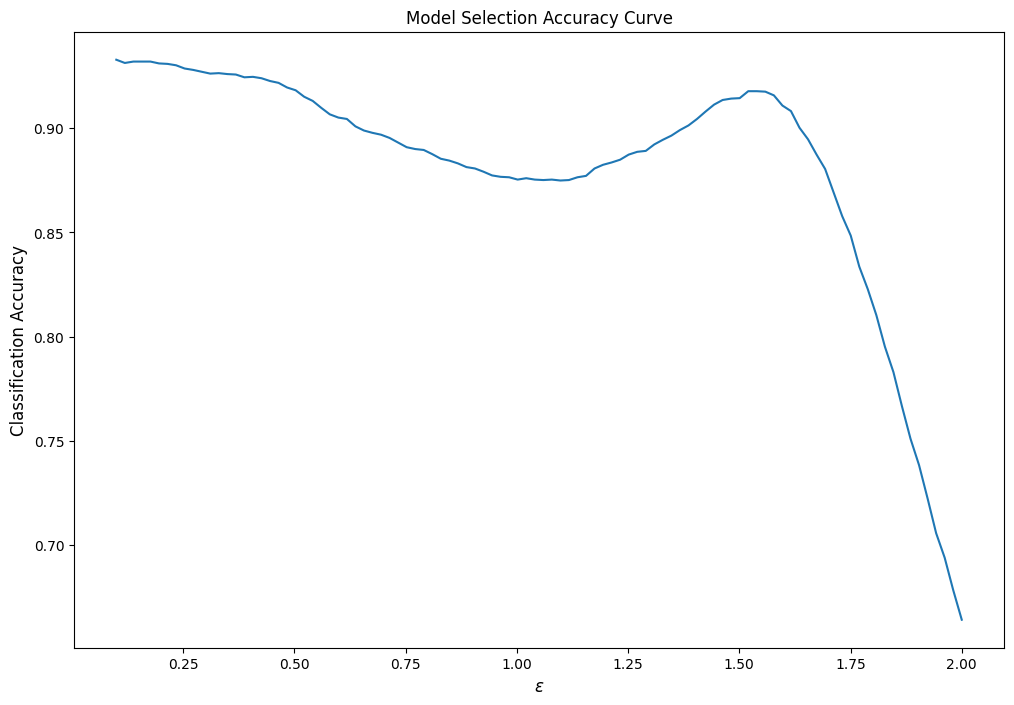

In [968]:
plt.figure(figsize=(12,8))
plt.plot(epsilons, accuracies)
plt.title('Model Selection Accuracy Curve')
plt.xlabel(r'$\epsilon$', fontsize=12)
plt.ylabel('Classification Accuracy', fontsize=12)
plt.show()

In [969]:
max_acc_idx = np.argmax(accuracies)
print(f'Max accuracy of {accuracies[max_acc_idx]:.3f} at epsilon = {epsilons[max_acc_idx]:.3f}')


Max accuracy of 0.933 at epsilon = 0.100


 now apply 10-fold CV style evaluation and stick error bars on things. Integrate confusion matrix for classification

In [1035]:
# create a KFold object with 10 splits 
kfold = KFold(n_splits=10, shuffle=True, random_state=0) # 80/20 split by default

# loop through the splits and train/test the model
scores = list()
count = 0
fold_accuracies = list() # meta-accuries (accuracies as fn of epsilon for each fold)

for train_index, test_index in kfold.split(sig):
    # get the training and testing data
    X_train, X_test = sig[train_index], sig[test_index] 
    y_train, y_test = labels_encoding[train_index], labels_encoding[test_index]

    #int(f'Train Data Size: {X_train.shape}')
    #print(f'Test Data Size: {X_test.shape}')
    # train the model
    pca_fit = PCA(n_components=2).fit(X_train[:, selected_features])
    pca_train = pca_fit.transform(X_train[:, selected_features])
    

    # evaluate the model
    pca_test = pca_fit.transform(X_test[:, selected_features])
    epsilons = np.linspace(0.05, 2, 100)
    accuracies = list()
    for epsilon in epsilons:
    # cycle through N validation samples
        predictions = list()
        for index, pos in enumerate(pca_test): 
            x, y = pos
            neighbours_idx = np.argwhere(((pca_train[:,0] - x)**2 + (pca_train[:,1] - y)**2) < epsilon**2)
            # check to see if neighbouring points exist for current epsilon value
            if len(neighbours_idx) == 0:
            # set to nearest point
                distances = np.linalg.norm(pca_train - pos, axis=1) # find nearest point, regardless of epsilon
                neighbours_idx = np.argmin(distances)
                lower_lim_eps.append(distances.min())

            neighbours = y_train[neighbours_idx] # get labels of neighbouring points
            unique, counts = np.unique(neighbours, return_counts=True)
            pred = unique[np.argmax(counts)]
            predictions.append(pred)
        matches = np.count_nonzero(predictions == y_test)
        accuracy = matches/len(y_test)
        accuracies.append(accuracy)

    print(f'Fold {count+1} test score: {np.max(accuracies):.3f}')
    scores.append(np.max(accuracies))
    count += 1
    fold_accuracies.append(accuracies)

print(f'Mean Classification Accuracy: {np.mean(scores):.3f} +/ {np.std(scores):.3f}')

Fold 1 test score: 0.949
Fold 2 test score: 0.959
Fold 3 test score: 0.947
Fold 4 test score: 0.951
Fold 5 test score: 0.939
Fold 6 test score: 0.961
Fold 7 test score: 0.957
Fold 8 test score: 0.953
Fold 9 test score: 0.939
Fold 10 test score: 0.957
Mean Classification Accuracy: 0.951 +/ 0.007


In [1002]:
mean_acc = np.mean(fold_accuracies, axis=0) # median accuracy across 10 folds for each epsilon
std_acc = np.std(fold_accuracies, axis=0)

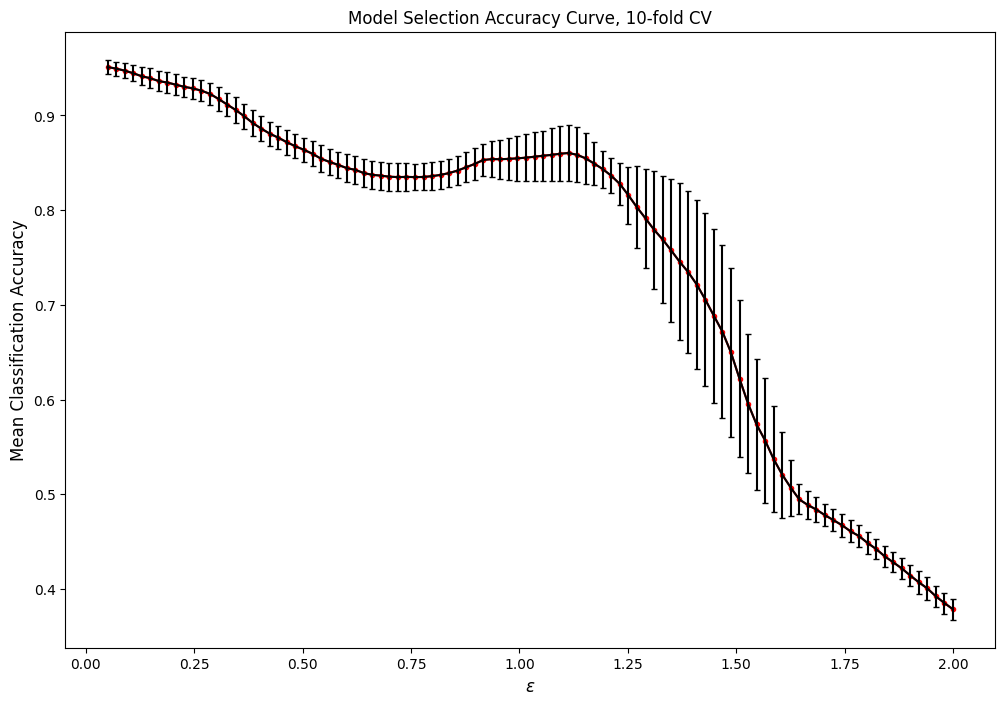

In [1003]:
plt.figure(figsize=(12,8))
plt.plot(epsilons, mean_acc, '.-', c='r')
plt.errorbar(epsilons, mean_acc, yerr=std_acc, capsize=2, c='k')
plt.title('Model Selection Accuracy Curve, 10-fold CV')
plt.xlabel(r'$\epsilon$', fontsize=12)
plt.ylabel('Mean Classification Accuracy', fontsize=12)
plt.show()

Similarity Matrix

In [1004]:
# 0 = FP, 1 = LC, 2 = BS
# on-diagonal terms
median_fp = statistics.median(pdist(pca_train[np.argwhere(y_train == 0).reshape(-1,)]))
median_lc = statistics.median(pdist(pca_train[np.argwhere(y_train == 1).reshape(-1,)]))
median_sw = statistics.median(pdist(pca_train[np.argwhere(y_train == 2).reshape(-1,)]))

# off-diagonal terms
median_fp_lc = statistics.median(cdist(pca_train[np.argwhere(y_train == 0).reshape(-1,)], pca_train[np.argwhere(y_train == 1).reshape(-1,)]).ravel())
median_fp_sw = statistics.median(cdist(pca_train[np.argwhere(y_train == 0).reshape(-1,)], pca_train[np.argwhere(y_train == 2).reshape(-1,)]).ravel())
median_lc_sw = statistics.median(cdist(pca_train[np.argwhere(y_train == 1).reshape(-1,)], pca_train[np.argwhere(y_train == 2).reshape(-1,)]).ravel())

In [1005]:
similarity_matrix = np.array([[median_fp, median_fp_lc, median_fp_sw], [median_fp_lc, median_lc, median_lc_sw], [median_fp_sw, median_lc_sw, median_sw]])
similarity_matrix/=np.max(similarity_matrix)
print(similarity_matrix)


[[0.34676737 1.         0.83341827]
 [1.         0.15380313 0.86223614]
 [0.83341827 0.86223614 0.26154995]]


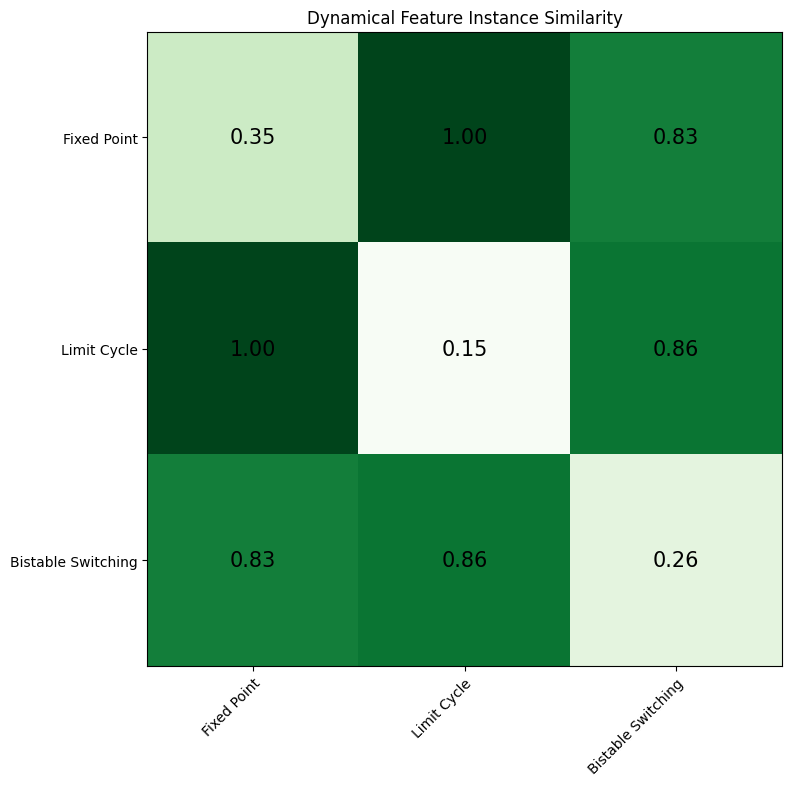

In [1007]:
labels = ['Fixed Point', 'Limit Cycle', 'Bistable Switching']
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(similarity_matrix, cmap='Greens')
ax.set_xticks(np.arange(len(labels)), labels=labels)
ax.set_yticks(np.arange(len(labels)), labels=labels)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(len(labels)):
    for j in range(len(labels)):
        text = ax.text(j, i, f'{similarity_matrix[i, j]:.2f}',
                       ha="center", va="center", fontsize=15)

ax.set_title("Dynamical Feature Instance Similarity")
fig.tight_layout()
#plt.savefig('dist_matrix.svg')
plt.show()

In [977]:
def greedy_forward_selection(X, y):
    remaining_features = list(np.arange(0,22)) # initial list of feature indices
    selected_features = list()
    current_score = 0 # store the current score for feature subset
    best_new_score = 0
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    while remaining_features:
        if len(selected_features) < 3:
            selected_features += remaining_features[:2]
            remaining_features = remaining_features[2:]
        else:
            scores = list()
            for feature in remaining_features:
                selected_features.append(feature)
                pca_fit = PCA(n_components=2).fit(X_train[:, selected_features]) # replace with dim. reduction method of choice
                pca_train = pca_fit.transform(X_train[:, selected_features])
                pca_test = pca_fit.transform(X_test[:, selected_features])
            
                epsilons = np.linspace(0.1, 2, 100)
                accuracies = list()

                for epsilon in epsilons:
                    # cycle through N validation samples
                    predictions = list()
                    for index, pos in enumerate(pca_test): 
                        # pca_subset
                        x, y = pos
                        neighbours_idx = np.argwhere(((pca_train[:,0] - x)**2 + (pca_train[:,1] - y)**2) < epsilon**2)
                        # check to see if neighbouring points exist for current epsilon value
                        if len(neighbours_idx) == 0:
                        # set to nearest point
                            distances = np.linalg.norm(pca_train - pos, axis=1) # find nearest point, regardless of epsilon
                            neighbours_idx = np.argmin(distances)

                        neighbours = y_train[neighbours_idx] # get labels of neighbouring points
                        unique, counts = np.unique(neighbours, return_counts=True)
                        pred = unique[np.argmax(counts)]
                        predictions.append(pred)
                    matches = np.count_nonzero(predictions == y_test)
                    accuracy = matches/len(y_test)
                    accuracies.append(accuracy)

                scores.append(np.max(accuracies))
                selected_features.pop()
            best_new_score = max(scores)
            if best_new_score > current_score:
                best_feature_index = scores.index(best_new_score)
                current_score = best_new_score
                selected_features.append(remaining_features[best_feature_index])
                remaining_features.pop(best_feature_index)
            else:
                break
    return selected_features, current_score

In [988]:
selected_features, score = greedy_forward_selection(sig, labels_encoding)

In [989]:
selected_features, score

([0, 1, 2, 3, 20, 15, 12, 4, 17], 0.9443518827057648)

In [990]:
pca_greedy = PCA(n_components=2).fit_transform(sig[:, selected_features])

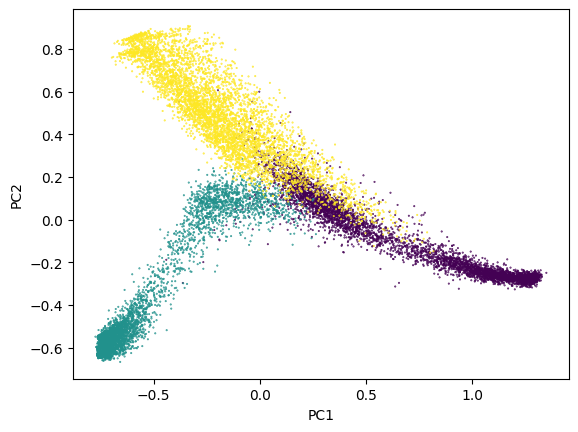

In [991]:
plt.scatter(pca_greedy[:,0], pca_greedy[:,1], c=labels_encoding, s=0.2)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.axis('equal')
plt.show()

In [1091]:
# create objective function for easy evaluation, assume X is pre-processed
# plots flag shows the corresponding instance space, instance class similarity matrix and epsilon curve
def evaluate(X, y, n_splits=5, show_plots=False):
    # perform 5 fold-CV and return max classification accuracy for any value of epsilon
    skfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=78765)
    scores = list() # save max accuracy achieved across each fold
    fold_acc = list() # store accuracies across each fold (for all epsilon)
    epsilons = np.linspace(0.05, 10, 100) # grid epsilons

    # evaluate max classification accuracy for each fold
    for i, (train_index, test_index) in enumerate(skfold.split(X, y)):
        t_start = perf_counter() # track time per fold
        # split data
        X_train, X_test = X[train_index], X[test_index] 
        y_train, y_test = y[train_index], y[test_index]

        # calibrate instance space
        pca_fit = PCA(n_components=2).fit(X_train)
        pca_train = pca_fit.transform(X_train)

        # project new instances into calibrated space and classify
        pca_test = pca_fit.transform(X_test)

        accuracies = list()

        # scan over epsilons 
        for epsilon in epsilons:
            predictions = list() # store predictions
            for pos in pca_test:
                x_pos, y_pos = pos
                neighbours_idx = np.argwhere(((pca_train[:,0] - x_pos)**2 + (pca_train[:,1] - y_pos)**2) < epsilon**2)
                # if no neighbouring pts, default to 1-NN
                if len(neighbours_idx) == 0:
                    # find nearest point
                    distances = np.linalg.norm(pca_train - pos, axis=1)
                    neighbours_idx = np.argmin(distances)
                
                neighbours = y_train[neighbours_idx]
                unique, counts = np.unique(neighbours, return_counts=True)
                pred = unique[np.argmax(counts)]
                predictions.append(pred)
            
            matches = np.count_nonzero(predictions == y_test)
            accuracy = matches/len(y_test)
            accuracies.append(accuracy)

        t_stop = perf_counter()
        print(f'Fold {i}: {np.max(accuracies):.4f} | Time Elapsed: {t_stop - t_start :.3f}s')
        scores.append(np.max(accuracies))
        fold_acc.append(accuracies)
    print('------------------------------------')
    print(f'Mean Classification Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

    # plotting
    if show_plots:
        #fig, ax = plt.subplots(3, 1, figsize=(12,36))

        # instance space
        fig1 = plt.figure(figsize=(12,8))
        pca_viz = PCA(n_components=2).fit_transform(X)
        plt.scatter(pca_viz[:, 0], pca_viz[:,1], s=0.5, c=y)
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.axis('equal')
        plt.title('Instance Space')
        plt.show()
    

        # epsilon curve
        mean_acc = np.mean(fold_acc, axis=0)
        std_acc = np.std(fold_acc, axis=0)

        fig2 = plt.figure(figsize=(12,8))
        plt.plot(epsilons, mean_acc, '.-', c='b')
        plt.errorbar(epsilons, mean_acc, yerr=std_acc, capsize=2, c='k')
        plt.title(f'Model Selection Epsilon Curve, {n_splits}-Fold CV')
        plt.xlabel(r'$\epsilon$', fontsize=12)
        plt.ylabel('Mean Classification Accuracy', fontsize=12)
        plt.show()

        # normalized instance similarity matrix with all data

        # compute diagonal terms
        median_fp = statistics.median(pdist(pca_viz[np.argwhere(y == 0).reshape(-1,)]))
        median_lc = statistics.median(pdist(pca_viz[np.argwhere(y == 1).reshape(-1,)]))
        median_sw = statistics.median(pdist(pca_viz[np.argwhere(y == 2).reshape(-1,)]))

        # compute off-diagonal terms
        median_fp_lc = statistics.median(cdist(pca_viz[np.argwhere(y == 0).reshape(-1,)], pca_viz[np.argwhere(y == 1).reshape(-1,)]).ravel())
        median_fp_sw = statistics.median(cdist(pca_viz[np.argwhere(y == 0).reshape(-1,)], pca_viz[np.argwhere(y == 2).reshape(-1,)]).ravel())
        median_lc_sw = statistics.median(cdist(pca_viz[np.argwhere(y == 1).reshape(-1,)], pca_viz[np.argwhere(y == 2).reshape(-1,)]).ravel())

        # construct matrix and normalize
        similarity_matrix = np.array([[median_fp, median_fp_lc, median_fp_sw], [median_fp_lc, median_lc, median_lc_sw], [median_fp_sw, median_lc_sw, median_sw]])
        similarity_matrix/=np.max(similarity_matrix)

        labels = ['Fixed Point', 'Limit Cycle', 'Bistable Switching']
        fig, ax = plt.subplots(figsize=(8,8))
        im = ax.imshow(similarity_matrix, cmap='Greens')
        ax.set_xticks(np.arange(len(labels)), labels=labels)
        ax.set_yticks(np.arange(len(labels)), labels=labels)
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

        for i in range(len(labels)):
            for j in range(len(labels)):
                text = ax.text(j, i, f'{similarity_matrix[i, j]:.2f}',
                       ha="center", va="center", fontsize=15)

        ax.set_title("Normalized Dynamical Feature Instance Similarity")
        fig.tight_layout()
        plt.show()




Fold 0: 0.9300 | Time Elapsed: 19.782s
Fold 1: 0.9294 | Time Elapsed: 19.672s
Fold 2: 0.9427 | Time Elapsed: 19.593s
Fold 3: 0.9520 | Time Elapsed: 19.428s
Fold 4: 0.9253 | Time Elapsed: 19.452s
Fold 5: 0.9287 | Time Elapsed: 19.403s
Fold 6: 0.9233 | Time Elapsed: 19.386s
Fold 7: 0.9307 | Time Elapsed: 19.386s
Fold 8: 0.9313 | Time Elapsed: 19.661s
Fold 9: 0.9333 | Time Elapsed: 19.695s
------------------------------------
Mean Classification Accuracy: 0.9327 +/- 0.0081


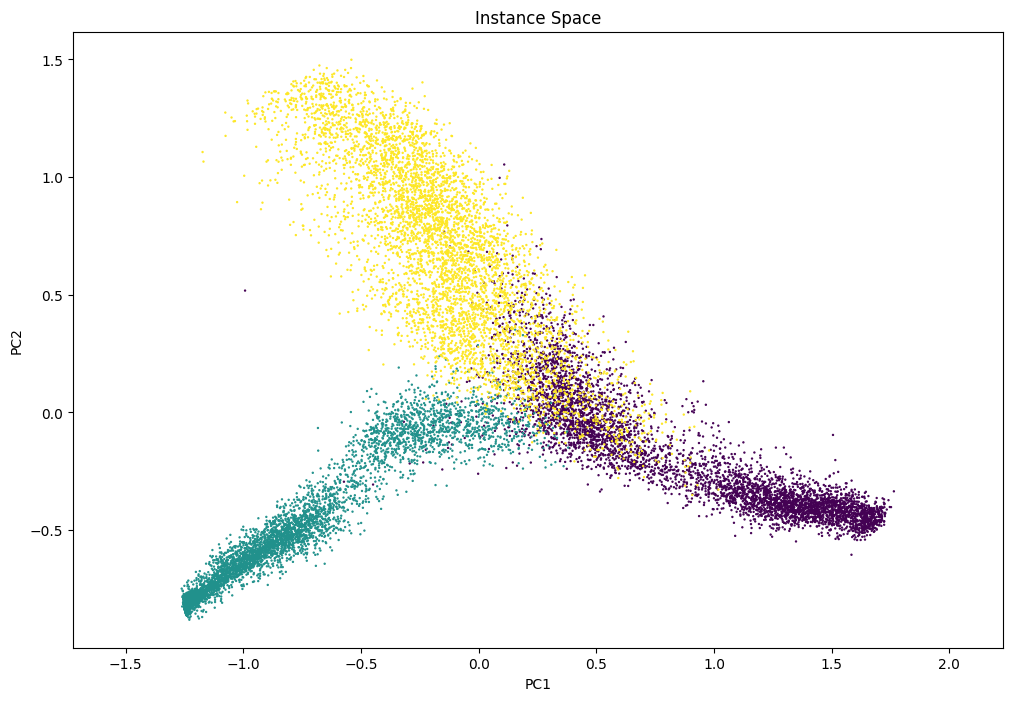

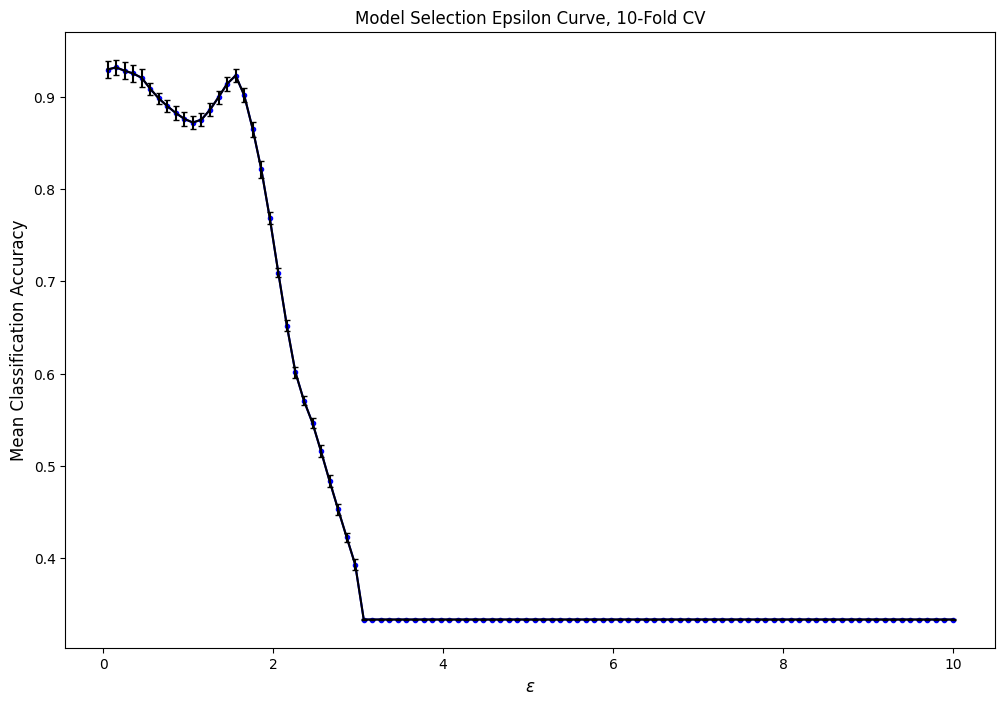

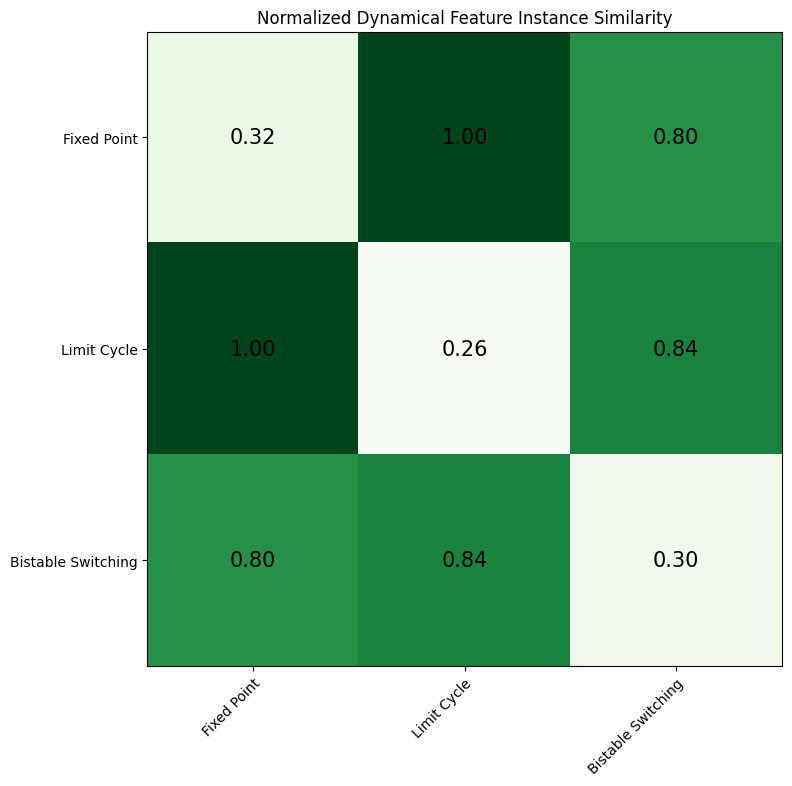

In [1092]:
evaluate(sig, labels_encoding, n_splits=10, show_plots=True)

## Getting Greedy

In [1149]:
class GreedyForwardSelection():

    def __init__(self, k_features):
        self.k_features = k_features # target number of features, termination conditon
        #self.model = clone(model)

    def fit(self, X_train, X_test, y_train, y_test):
        max_idx = tuple(range(X_train.shape[1])) # get feature idxs
        total_features_count = len(max_idx) # initial num of features
        self.subsets_ = list()
        self.scores_ = list()
        self.indices_ = list()

        scores = list()
        subsets = list()
        
        for p in combinations(max_idx, r=1):
            # train on all possible first features
            score = self._calc_score(X_train, X_test, y_train, y_test, p)
            
            scores.append(score)
            subsets.append(p)

        best_score_idx = np.argmax(scores)
        self.scores_.append(scores[best_score_idx])
        self.indices_ = list(subsets[best_score_idx])
        self.subsets_.append(self.indices_)
        print(f'Best score: {self.scores_[-1]}')

        # add features sequentially until k_features is reached
        current_k = 1
        while current_k < self.k_features:
            scores = list()
            subsets = list()

            idx = 0
            while idx < total_features_count:
                if idx not in self.indices_:
                    indices = list(self.indices_)
                    indices.append(idx)
                    score = self._calc_score(X_train, X_test, y_train, y_test, indices)
                    scores.append(score)
                    subsets.append(indices)
                    
                idx += 1
            
            best_score_idx = np.argmax(scores)
            self.scores_.append(scores[best_score_idx])
            self.indices_ = list(subsets[best_score_idx])
            self.subsets_.append(self.indices_)
            current_k += 1
            print(f'k = {current_k}, Best score: {self.scores_[-1]}')
        self.k_score_ = self.scores_[-1]

    # output data matrix using reduced subset of features
    def transform(self, X):
        return X[:, self.indices_]

    ##def _calc_score(self, X_train, X_test, y_train, y_test, indices):
       # self.model.fit(X_train[:, indices], y_train)
       # score = self.model.score(X_test[:, indices], y_test)
       # return score

    # add custom calc score function for pca
    def _calc_score(self, X_train, X_test, y_train, y_test, indices):
        epsilon_range = np.linspace(0.05, 2, 20)
        components = len(indices)
        accuracies = list()

        # if dim greater than 1, set target components to 2 for visualization
        if components > 1:
            components = 2

        # train model
        pca_fit = PCA(n_components=components).fit(X_train[:, indices])
        pca_train = pca_fit.transform(X_train[:, indices])

        # project test instances
        pca_test = pca_fit.transform(X_test[:, indices])

        for epsilon in epsilon_range:
            predictions = list()
            for test_instance in pca_test:
                neighbours_idx = np.argwhere(np.linalg.norm(pca_train - test_instance, axis=1) < epsilon)

                # if no neighbouring points in epsilon radius, use 1-NN
                if len(neighbours_idx) == 0:
                    distances = np.linalg.norm(pca_train - test_instance, axis=1)
                    neighbours_idx = np.argmin(distances)
                
                neighbour_pts = y_train[neighbours_idx]
                unique, counts = np.unique(neighbour_pts, return_counts=True)
                pred = unique[np.argmax(counts)]
                predictions.append(pred)
            matches = np.count_nonzero(predictions == y_test)
            acc = matches / len(y_test)
            accuracies.append(acc)
        
        best_score = np.max(accuracies) # return max acc achieved across all epsilons
        return best_score

In [1150]:
gfs = GreedyForwardSelection(k_features=9)
X_train, X_test, y_train, y_test = train_test_split(sig, labels_encoding, test_size=0.2, random_state=123)

In [1151]:
gfs.fit(X_train, X_test, y_train, y_test)

Best score: 0.895034988337221
k = 2, Best score: 0.9543485504831722
k = 3, Best score: 0.9560146617794069
k = 4, Best score: 0.9583472175941353
k = 5, Best score: 0.9580139953348884
k = 6, Best score: 0.9570143285571476
k = 7, Best score: 0.9560146617794069
k = 8, Best score: 0.9560146617794069
k = 9, Best score: 0.9560146617794069


In [1229]:
selected_subset = gfs.indices_
selected_subset

[2, 17, 4, 15, 11, 21, 12, 0, 20]

In [1310]:
## Non-K Fold Evaluation - Hold out set over several trials to get statistics
def evaluate_non_kf(X, y, trials=5): # n_per_class = number of instances per class to use for evaluation
    accs = list()
    for trial in range(trials):
        print(f'Trial: {trial}')
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        pca_fit = PCA(n_components=2).fit(X_train)
        pca_train = pca_fit.transform(X_train)
        pca_test = pca_fit.transform(X_test)
        epsilons = np.linspace(0.1, 2, 20)
        for epsilon in epsilons:
            predictions = list()
            for index, test_instance in enumerate(pca_test):
                neighbours_idx = np.argwhere(np.linalg.norm(pca_train - test_instance, axis=1) < epsilon)
                if len(neighbours_idx) == 0:
                    distances = np.linalg.norm(pca_train - test_instance, axis=1)
                    neighbours_idx = np.argmin(distances)
                
                neighbour_pts = y_train[neighbours_idx]
                unique, counts = np.unique(neighbour_pts, return_counts=True)
                pred = unique[np.argmax(counts)]
                predictions.append(pred)
            matches = np.count_nonzero(predictions == y_test)
            acc = matches / len(y_test)
            accs.append(acc)
    return accs
                



In [1311]:
out = evaluate_non_kf(sig, labels_encoding, trials=5)

Trial: 0
Trial: 1
Trial: 2
Trial: 3
Trial: 4


In [1265]:
# plot separate accuracies for each model and overall/aggregate curve
def evaluate_new(X, y, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)
    fold_overall_acc = list()
    fold_lc_acc = list()
    fold_fp_acc = list()
    fold_bs_acc = list()


    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        pca_fit = PCA(n_components=2).fit(X_train)
        pca_train = pca_fit.transform(X_train)
        accuracies_overall = list()
        accuracies_fp = list()
        accuracies_lc = list()
        accuracies_bs = list()

        # eval model
        pca_test = pca_fit.transform(X_test)

        plt.plot(pca_train)
        epsilon_range = np.linspace(0.1, 2, 50)
        for epsilon in epsilon_range:
            predictions = list()
            for test_instance in pca_test:
                neighbours_idx = np.argwhere(np.linalg.norm(pca_train - test_instance, axis=1) < epsilon)
                # if no neighbouring points in epsilon radius, use 1-NN
                if len(neighbours_idx) == 0:
                    distances = np.linalg.norm(pca_train - test_instance, axis=1)
                    neighbours_idx = np.argmin(distances)
                
                neighbour_pts = y_train[neighbours_idx]
                unique, counts = np.unique(neighbour_pts, return_counts=True)
                pred = unique[np.argmax(counts)]
                predictions.append(pred)
            matches_fp = np.count_nonzero((y_test == 0) & (predictions == y_test)) # 0 = FP, 1 = LC, 2 = BS
            matches_lc = np.count_nonzero((y_test == 1) & (predictions == y_test))
            matches_bs = np.count_nonzero((y_test == 2) & (predictions == y_test))
            matches_overall = np.count_nonzero(predictions == y_test)

            acc_fp = matches_fp/np.sum(y_test == 0)
            acc_lc = matches_lc/np.sum(y_test == 1)
            acc_bs = matches_bs/np.sum(y_test == 2)
            acc_overall = matches_overall/len(y_test)
            accuracies_fp.append(acc_fp)
            accuracies_lc.append(acc_lc)
            accuracies_bs.append(acc_bs)
            accuracies_overall.append(acc_overall)
        
        print(f'Fold: {i} | FP ACC: {np.max(accuracies_fp)} | LC ACC: {np.max(accuracies_lc)} | BS ACC: {np.max(accuracies_bs)} | Overall ACC: {np.max(accuracies_overall)}')
        fold_overall_acc.append(accuracies_overall)
        fold_lc_acc.append(accuracies_lc)
        fold_fp_acc.append(accuracies_fp)
        fold_bs_acc.append(accuracies_bs)

    # calc mean accuracy and std across folds for each invidual class and overall
    mean_acc_overall = np.mean(fold_overall_acc, axis=0)
    std_acc_overall = np.std(fold_overall_acc, axis=0)
    mean_acc_lc = np.mean(fold_lc_acc, axis=0)
    std_acc_lc = np.std(fold_lc_acc, axis=0)
    mean_acc_fp = np.mean(fold_fp_acc, axis=0)
    std_acc_fp = np.std(fold_fp_acc, axis=0)
    mean_acc_bs = np.mean(fold_bs_acc, axis=0)
    std_acc_bs = np.std(fold_bs_acc, axis=0)

    # plot
    plt.figure(figsize=(10, 8))
    plt.plot(epsilon_range, mean_acc_overall, label='Overall Accuracy')
    plt.plot(epsilon_range, mean_acc_lc, label='Limit Cycle')
    plt.plot(epsilon_range, mean_acc_fp, label='Fixed Point')
    plt.plot(epsilon_range, mean_acc_bs, label='Bistable Switching')
    plt.fill_between(epsilon_range, mean_acc_overall - std_acc_overall, mean_acc_overall + std_acc_overall, alpha=0.8)
    plt.legend()
    
    